# Projeto Final Data Wrangling - WeRateDogs

In [8]:
# Importando as bibliotecas para este projeto
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import time
import json
import re
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Fase 1 - Coleta de Dados

### Nesta fase sera efetuada a coleta dos dados de diversas fontes para a elaboração da análise.

#### Twitter Archive

In [9]:
# Lendo o primeiro arquivo de dados csv "twitter-archive-enhanced.csv" e colocando o conteudo em um dataframe.
twitter_arq = pd.read_csv('twitter-archive-enhanced.csv', encoding = 'utf-8')

#### Image Prediction

In [10]:
# Lendo o segundo arquivo de dados online e colocando o conteudo em um arquivo local "image_predictions.tsv".
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(url.split('/')[-1], mode = 'wb') as outfile:
    outfile.write(response.content)
    
# Criando um dataframe com o conteudo coletado da internet.
imgs = pd.read_csv('image-predictions.tsv', sep = '\t', encoding = 'utf-8')

#### Twitter JSON

In [11]:
# Coletando a terceira base de dados com a API do Twitter.
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

# Criando uma instancia do OAuthHandler
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Construindo a API
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [27]:
# Criando um Dataframe com as ids dos tweets.
list_of_ids = twitter_arq['tweet_id'].tolist()


In [28]:
# We then fetch all tweets from the twitter API using the following loop:
list_of_tweets = []
# Tweets that can't be found are saved in the list below:
list_of_errors = []
for each_id in list_of_ids:   
    try:
#        start = time.time()
        list_of_tweets.append(api.get_status(each_id))
#        end = time.time()
#        print(end - start)
    except Exception as e:
        list_of_errors.append(each_id)
#        print(str(each_id))

Rate limit reached. Sleeping for: 607
Rate limit reached. Sleeping for: 506


In [29]:
# Criando o arquivo tweet_json.txt a partir dos tweets
my_list_of_dicts = []
for each_json_tweet in list_of_tweets:
    my_list_of_dicts.append(each_json_tweet._json)
with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(my_list_of_dicts, indent=4))

In [12]:
# Criando dataframe a partid do tweet_json.txt
my_demo_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count'] 
        created_at = each_dictionary['created_at']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        my_demo_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'url': url,
                             'created_at': created_at,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        tweet_json = pd.DataFrame(my_demo_list, columns = ['tweet_id', 'favorite_count', 
                                                       'retweet_count', 'created_at',
                                                       'source', 'retweeted_status', 'url'])


## Fase 2 - Avaliando os Dados

### Twitter Archive

In [13]:
# Vamos analisar primeiro o arquivo com os tweets em busca de problemas de qualidade e arrumação.
# Como algumas partes deste arquivo contém strings longas modificamos as opções de visualizaçāo.
pd.options.display.max_colwidth = 10000
twitter_arq

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [14]:
# As colunas in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id 
# e retweeted_status_timestamp contem uma serie de NaN.
# A coluna expanded_urls em alguns casos tem mais de uma url.
# As colunas doggo, flooter, pupper e puppo pode ser mescladas posteriormente.

In [15]:
# Tipos de dados em cada coluna
twitter_arq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [16]:
# Podemos verificar que na coluna expanded_urls existem alguns dados faltando.
# Estes dados podem ser respostas ao tweets que nāo possuem urls.
# Vamos verificar se existe algum tweet sem resposta no dataframe.
twitter_arq[twitter_arq['expanded_urls'].isnull()].loc[:,['expanded_urls', 
                                                                  'in_reply_to_status_id', 
                                                                  'in_reply_to_user_id',
                                                                 'retweeted_status_id']]

,expanded_urls,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id
30,NaN,8.862664e+17,2.281182e+09,NaN
55,NaN,8.816070e+17,4.738443e+07,NaN
64,NaN,8.795538e+17,3.105441e+09,NaN
113,NaN,8.707262e+17,1.648776e+07,NaN
148,NaN,8.634256e+17,7.759620e+07,NaN
179,NaN,8.571567e+17,1.806710e+08,NaN
185,NaN,NaN,NaN,8.563302e+17
186,NaN,8.562860e+17,2.792810e+08,NaN
188,NaN,8.558616e+17,1.943518e+08,NaN
189,NaN,8.558585e+17,1.361572e+07,NaN


In [17]:
# Verificamos que somente 4 tweets não tiveram respostas.
# Vamos analisar estes 4 tweets mais de perto.
non_url_non_replies_ids = twitter_arq.iloc[[185, 375, 707, 1445],:].tweet_id
twitter_arq.iloc[[185, 375, 707, 1445],:]
# Podemos verificar posteriormente nos dados coletados via API se conseguimos achar as urls
# destes tweets faltantes.

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Jenna_Marbles: @dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
375,828361771580813312,NaN,NaN,2017-02-05 21:56:51 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Beebop and Doobert should start a band 12/10 would listen,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
707,785515384317313025,NaN,NaN,2016-10-10 16:20:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Today, 10/10, should be National Dog Rates Day",NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
1445,696518437233913856,NaN,NaN,2016-02-08 02:18:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Oh my god 10/10 for every little hot dog pupper,NaN,NaN,NaN,NaN,10,10,None,None,None,pupper,None


In [18]:
# Utilizando o describe no dataframe.
twitter_arq.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [19]:
# Os denominadores de avaliação Min e Max não estão funcionando muito bem.
twitter_arq.nsmallest(10, 'rating_numerator')[['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
315,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10
1016,"PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",0,10
605,RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…,1,10
1446,After reading the comments I may have overestimated this pup. Downgraded to a 1/10. Please forgive me,1,10
1869,What kind of person sends in a picture without a dog in it? 1/10 just because that's a nice table https://t.co/RDXCfk8hK0,1,10
1940,The millennials have spoken and we've decided to immediately demote to a 1/10. Thank you,1,10
2038,After 22 minutes of careful deliberation this dog is being demoted to a 1/10. The longer you look at him the more terrifying he becomes,1,10
2091,Flamboyant pup here. Probably poisonous. Won't eat kibble. Doesn't bark. Slow af. Petting doesn't look fun. 1/10 https://t.co/jxukeh2BeO,1,10
2261,Never seen dog like this. Breathes heavy. Tilts head in a pattern. No bark. Shitty at fetch. Not even cordless. 1/10 https://t.co/i9iSGNn3fx,1,10
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,2


In [20]:
twitter_arq.nlargest(10, 'rating_numerator')[['text', 'rating_numerator', 'rating_denominator']]


,text,rating_numerator,rating_denominator
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
189,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666,10
188,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420,10
2074,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420,10
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
290,@markhoppus 182/10,182,10
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1779,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,144,120
1634,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143,130


In [21]:
twitter_arq.nsmallest(10, 'rating_denominator')[['text', 'rating_numerator', 'rating_denominator']]


,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,2
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
0,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10
1,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10
2,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10
3,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10
4,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10
5,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,13,10
6,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,13,10


In [22]:
twitter_arq.nlargest(10, 'rating_denominator')[['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1634,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143,130
1779,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,144,120
1635,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121,110
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1843,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw,88,80
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [23]:
# Nos quatro DataFrames acima, podemos ver que classificações extremas no rating_numerator e rating_denominator
# estão amplamente alinhadas com o texto do twitter, então nossa hipótese acima não é verdadeira.
# Mas se verificarmos, ou seja, o tweet no índice 313 (o primeiro tweet no terceiro DataFrame) ou o tweet em
# índice 2335 (no primeiro DataFrame o último tweet), podemos ver que a primeira relação encontrada no texto
# foi usado para preencher o numerador e denominador de classificação que claramente não é um procedimento ideal,
# tweets parecem ter mais de uma proporção no texto do corpo. Então, precisamos consertar isso.

In [24]:
# Usando o sample para verificar outros problemas.
twitter_arq.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
462,817502432452313088,NaN,NaN,2017-01-06 22:45:43 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Herschel. He's slightly bigger than ur average pupper. Looks lonely. Could probably ride 7/10 would totally pet https:/…,6.924173e+17,4.196984e+09,2016-01-27 18:42:06 +0000,https://twitter.com/dog_rates/status/692417313023332352/photo/1,7,10,Herschel,None,None,pupper,None
307,835685285446955009,NaN,NaN,2017-02-26 02:57:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Rory. He's got an interview in a few minutes. Looking spiffy af. Nervous as h*ck tho. 12/10 would hire https://t.co/…,7.869631e+17,4.196984e+09,2016-10-14 16:13:10 +0000,https://twitter.com/dog_rates/status/786963064373534720/photo/1,12,10,Rory,None,None,None,None
1258,710283270106132480,NaN,NaN,2016-03-17 01:55:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Gunner. He's a Figamus Newton. King of the peek-a-boo. Cool jeans. 11/10 https://t.co/ONuBILIYXZ,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/710283270106132480/photo/1,https://twitter.com/dog_rates/status/710283270106132480/photo/1",11,10,Gunner,None,None,None,None
574,801127390143516673,NaN,NaN,2016-11-22 18:17:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Anakin. He strives to reach his full doggo potential. Born with blurry tail tho. 11/10 would still pet well https://…,7.757333e+17,4.196984e+09,2016-09-13 16:30:07 +0000,https://twitter.com/dog_rates/status/775733305207554048/photo/1,11,10,Anakin,doggo,None,None,None
1522,690649993829576704,NaN,NaN,2016-01-22 21:39:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Hazel. She's a gymnast. Training hard for Rio. 11/10 focused af https://t.co/CneG2ZbxHP,NaN,NaN,NaN,https://twitter.com/dog_rates/status/690649993829576704/photo/1,11,10,Hazel,None,None,None,None


In [25]:
# Seria útil dividir a coluna do registro de data e hora em duas colunas: data e hora.
# Além disso, a coluna de origem contém um URL seguido de texto, que deve ser limpo.
# Por fim, no final de cada tweet, a url do tweet está presente e deve ser limpa.

#### Dados do twitter-archive-enhanced.csv

###### Problemas de Qualidade

* Retweets presentes no DataFrame (só queremos tweets originais com imagens).
* As colunas relevantes para os retweets precisam ser descartadas (queremos apenas tweets originais com imagens).
* Tipo de dados incorreto para tweet_id.
* Valores errados de rating_nominator e rating_denominator.
* Limpar o URL do texto do tweet.

###### Problemas de Arrumação

* A coluna expanded_urls contém em algumas células vários URLs que devem ser limpos.
* Os dados da coluna de origem contêm código html que deve ser limpo.
* Quatro variáveis doggo, floofer, pupper e puppo devem ser fundidas em uma coluna.
* Timestamp deve ser dividido em data e hora.

### Image Predictions

In [26]:
# Agora vamos analisar o DataFrame com as imagens
pd.options.display.max_colwidth = 10000
imgs

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [27]:
# Muitos nomes de raças de cães estão em letras minúsculas nas colunas p1, p2 e p3.
# É melhor capitalizar todos os nomes nessas colunas para trabalhar com
# dados consistentes.
# Diversas colunas possuem nomes não descritivos (p1, p1_conf, p1_dog, p2,
# p2_conf, p2_dog, p3, p3_conf, p3_dog

In [28]:
imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [29]:
# Devemos alterar o tipo de dados tweet_id.

In [30]:
imgs.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [31]:
imgs.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
753,688179443353796608,https://pbs.twimg.com/media/CYznjAcUEAQ5Zq7.jpg,1,sorrel,0.811520,False,horse_cart,0.024820,False,Arabian_camel,0.015155,False
338,672239279297454080,https://pbs.twimg.com/media/CVRGDrsWsAAUWSF.jpg,1,pug,0.332536,True,French_bulldog,0.258124,True,bull_mastiff,0.120873,True
1430,773191612633579521,https://pbs.twimg.com/media/CrrtqjdXEAINleR.jpg,1,Blenheim_spaniel,0.427766,True,Shih-Tzu,0.219256,True,Welsh_springer_spaniel,0.144614,True
775,689659372465688576,https://pbs.twimg.com/media/CZIpimOWcAETFRt.jpg,1,bustard,0.225221,False,koala,0.057625,False,goose,0.053569,False
539,676957860086095872,https://pbs.twimg.com/ext_tw_video_thumb/676957802976419840/pu/img/dCj-qlXo73A5hf6Q.jpg,1,Labrador_retriever,0.772423,True,beagle,0.055902,True,golden_retriever,0.031152,True


In [32]:
# Nada de anormal com as estatisticas neste DataFrame.

#### Dados do image-predictions.tsv

###### Problemas de Qualidade

* Tipo de dados incorreto para tweet_id.
* Nomes de raça de cachorro minúsculos.
* Nomes de colunas não descritivos para várias variáveis.

### Twitter JSON

In [33]:
# Vamos verificar os dados que coletamos na API do Twitter.
pd.options.display.max_colwidth = 10000
tweet_json

,tweet_id,favorite_count,retweet_count,created_at,source,retweeted_status,url
0,892420643555336193,38297,8394,Tue Aug 01 16:23:56 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,32824,6196,Tue Aug 01 00:17:27 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,24711,4100,Mon Jul 31 00:18:03 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,41615,8528,Sun Jul 30 15:58:51 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,39789,9242,Sat Jul 29 16:00:24 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3
5,891087950875897856,19980,3073,Sat Jul 29 00:08:17 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/xx5cilW0Dd
6,890971913173991426,11693,2040,Fri Jul 28 16:27:12 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/MV01Q820LT
7,890729181411237888,64632,18635,Fri Jul 28 00:22:40 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/hrcFOGi12V
8,890609185150312448,27463,4214,Thu Jul 27 16:25:51 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/UkrdQyoYxV
9,890240255349198849,31510,7290,Wed Jul 26 15:59:51 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/l3TSS3o2M0


In [34]:
# A partir do DataFrame acima, buscaremos as colunas favorite_count e retweet_count
# e adicionamos ao DataFrame twitter_archive. Então, precisamos atualizar a limpeza
# questões da tabela de arquivo do twitter. Também vamos usar a coluna de origem para atualizar
# a coluna de origem da tabela de arquivo do twitter. Nós já documentamos a necessidade
# para limpar a coluna de origem na avaliação do arquivo do Twitter.

In [35]:
# Como uma verificação cruzada, vamos ver se os retweets no DataFrame do Twitter são identificados como
# retweets no DataFrame tweet_json:
tw_arch_retw = twitter_arq[twitter_arq['retweeted_status_id'].notnull()]['tweet_id'].tolist()
tweet_json_retw = tweet_json[tweet_json['retweeted_status'] == "This is a retweet" ]['tweet_id'].tolist()
tweet_json['retweeted_status'].value_counts()


Original tweet       2174
This is a retweet     167
Name: retweeted_status, dtype: int64

In [36]:
# Verificando tipos de dados de listas recém-criadas.
print(type(tw_arch_retw[0]))
print(type(tweet_json_retw[0]))

<class 'int'>
<class 'str'>


In [37]:
# Convertendo listas de strings para listas de ints para verificar elementos comuns.
tweet_json_retw = list(map(int, tweet_json_retw))

In [38]:
# Contando o numero de elementos comuns.
len(list(set(tw_arch_retw).intersection(tweet_json_retw)))

167

In [39]:
len(tw_arch_retw)

181

In [40]:
# Parece que usando a coluna retweeted_status_id no DataFrame do Twitter-archive
# podemos excluir retweets do nosso conjunto de dados.
# Note que existem sete retweets que não foram encontrados na API do Twitter e
# infelizmente não podemos fazer algo sobre isso.
# Vamos também ver se conseguimos encontrar os URLs dos quatros tweets que não foram respondidos.

In [41]:
tweet_json[tweet_json['tweet_id'].isin(list(map(str, non_url_non_replies_ids)))]

,tweet_id,favorite_count,retweet_count,created_at,source,retweeted_status,url
179,856330835276025856,0,702,Mon Apr 24 02:15:55 +0000 2017,Twitter for iPhone,This is a retweet,This is a retweet
366,828361771580813312,2334,184,Sun Feb 05 21:56:51 +0000 2017,Twitter Web Client,Original tweet,n
695,785515384317313025,6559,1389,Mon Oct 10 16:20:36 +0000 2016,Twitter for iPhone,Original tweet,y
1430,696518437233913856,4104,1820,Mon Feb 08 02:18:30 +0000 2016,Twitter for iPhone,Original tweet,r


In [42]:
# Podemos verificar que as urls faltantes também não estão neste dataset, porém não há previsões de imagem para eles, então eles seriam descartados de qualquer maneira..

In [43]:
imgs[imgs['tweet_id'].isin(list(map(str, non_url_non_replies_ids)))]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [44]:
# Verificando as informações DataFrame
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 7 columns):
tweet_id            2341 non-null object
favorite_count      2341 non-null int64
retweet_count       2341 non-null int64
created_at          2341 non-null object
source              2341 non-null object
retweeted_status    2341 non-null object
url                 2341 non-null object
dtypes: int64(2), object(5)
memory usage: 128.1+ KB


In [45]:
tweet_json.describe()

,favorite_count,retweet_count
count,2341.000000,2341.000000
mean,8015.460914,2955.213157
std,12379.356765,4967.306493
min,0.000000,0.000000
25%,1388.000000,594.000000
50%,3492.000000,1381.000000
75%,9828.000000,3451.000000
max,165067.000000,84346.000000


In [46]:
tweet_json.sample(5)

,tweet_id,favorite_count,retweet_count,created_at,source,retweeted_status,url
1370,700747788515020802,24105,10068,Fri Feb 19 18:24:26 +0000 2016,Twitter for iPhone,Original tweet,https://t.co/22x9SbCYCU
513,809220051211603969,21457,6222,Thu Dec 15 02:14:29 +0000 2016,Twitter for iPhone,Original tweet,https://t.co/2JjYys5zMP
1343,703382836347330562,3701,1226,Sat Feb 27 00:55:11 +0000 2016,Twitter for iPhone,Original tweet,https://t.co/B9dOrmnPVt
1189,716080869887381504,5134,1865,Sat Apr 02 01:52:38 +0000 2016,Twitter for iPhone,Original tweet,https://t.co/UACnoyi8zu
2308,666428276349472768,166,83,Tue Nov 17 01:30:57 +0000 2015,Twitter for iPhone,Original tweet,https://t.co/NMQq6HIglK


In [47]:
# Nada de incomum aparece nas informações do Dataframe.

#### Dados do Twitter JSON

###### Problemas de Arrumação

* As colunas favorite_count e retweet_count estão ausentes.

Para resumir a tabela twitter_arq tem 5 problemas de qualidade e 5 de arrumação. Além disso, a tabela imgs possui 3 problemas de qualidade.

## Fase 3 - Limpeza dos Dados

In [49]:
# Fazendo a copia dos 3 DataFrames
twitter_archive_clean = twitter_arq.copy()
image_predictions_clean = imgs.copy()
tweet_json_clean = tweet_json.copy()

### Problemas de Qualidade

##### Twitter Archive

###### Retweets presente no DataFrame.


Usaremos o 'retweed_status_id' para eliminar os retweets. Em seguida, usaremos o 'tweet_id' do DataFrame image_predictions_clean para manter apenas os tweets com imagens.

In [50]:
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean.tweet_id.isin(tw_arch_retw)]

In [51]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [52]:
# Isolando os ids do DataFrame de imagens
image_pred_ids = image_predictions_clean['tweet_id'].tolist()

In [53]:
# Isolando os idsdos tweets originais.
twitter_archive_clean_ids = twitter_archive_clean['tweet_id'].tolist()

In [54]:
print(type(image_pred_ids[0]))
print(type(twitter_archive_clean_ids[0]))

<class 'int'>
<class 'int'>


In [55]:
# Contando o numero de elementos comuns entre as duas listas.
print(len(list(set(image_pred_ids).intersection(twitter_archive_clean_ids))))

1994


In [56]:
# Salvando os 1994 tweets originais.
original_tweets_with_image_prediction_ids = list(set(image_pred_ids).intersection(twitter_archive_clean_ids))

In [57]:
# Deixando somente os tweets originais com suas imagens.
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.tweet_id.isin(original_tweets_with_image_prediction_ids)]

In [58]:
# Testando o resultado.
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null object
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
dtypes: float64(4), int64(3), object(1

###### As colunas relevantes para os retweets precisam ser descartadas (queremos apenas tweets originais com imagens).

Utilizando o pandas.DataFrame.drop para se livrar das colunas relacionadas a retweets e respostas.

In [59]:
twitter_archive_clean = twitter_archive_clean.drop(['retweeted_status_id', 
                                                    'retweeted_status_user_id', 
                                                    'retweeted_status_timestamp', 
                                                    'in_reply_to_status_id', 
                                                    'in_reply_to_user_id'],
                                                   axis=1)

In [60]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null object
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
doggo                 1994 non-null object
floofer               1994 non-null object
pupper                1994 non-null object
puppo                 1994 non-null object
dtypes: int64(3), object(9)
memory usage: 202.5+ KB


###### Tipo de dados incorreto para tweet_id.

Convertendo a coluna tweet_id em string.

In [61]:
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype('str')

In [62]:
# Testando
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              1994 non-null object
timestamp             1994 non-null object
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
doggo                 1994 non-null object
floofer               1994 non-null object
pupper                1994 non-null object
puppo                 1994 non-null object
dtypes: int64(2), object(10)
memory usage: 202.5+ KB


###### Valores errados de rating_nominator e rating_denominator.

Criando uma nova coluna que armazene todas as proporções encontradas na coluna "text". Use-o para eliminar tweets que contenham mais de uma proporção.

In [63]:
saved_ratios = []
for my_index in twitter_archive_clean.index.tolist():
    ratio = re.findall(r'\d+/\d+', twitter_archive_clean.loc[my_index, 'text'])
    saved_ratios.append(ratio)

In [64]:
twitter_archive_clean['rating'] = saved_ratios

In [65]:
indexes_of_double_ratios = []
for my_index in twitter_archive_clean.index.tolist():
    if len(twitter_archive_clean.loc[my_index, 'rating']) > 1:
        indexes_of_double_ratios.append(my_index)


In [66]:
twitter_archive_clean.loc[indexes_of_double_ratios, 
                          ['text', 'rating_numerator', 'rating_denominator',
                          'url', 'rating']]

/Users/shinobi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


,text,rating_numerator,rating_denominator,url,rating
766,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",12,10,NaN,"[12/10, 11/10]"
1007,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,10,10,NaN,"[10/10, 7/10]"
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11,NaN,"[9/11, 14/10]"
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20,NaN,"[4/20, 13/10]"
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50,NaN,"[50/50, 11/10]"
1222,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE,10,10,NaN,"[10/10, 8/10]"
1359,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10 https://t.co/8rc5I22bBf,9,10,NaN,"[9/10, 2/10]"
1459,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",4,10,NaN,"[4/10, 13/10]"
1465,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10 https://t.co/6NgsQJuSBJ,10,10,NaN,"[10/10, 5/10]"
1508,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,5,10,NaN,"[5/10, 10/10]"


In [67]:
len(indexes_of_double_ratios)

27

In [68]:
# Existem apenas 27 tweets com mais de uma proporção no texto.
# Na maioria das vezes, o motivo de ter mais de uma classificação é que o
# imagem anexada ao tweet tem mais de 1 animal representado
# (geralmente um segundo cachorro).
# Como consequência, as colunas rating_numerator e rating_denominator
# contém apenas a primeira relação encontrada no texto do tweet, que é
# claramente não é o ideal. Devemos notar que, para alguns tweets, o rácio adicional é
# não relacionado a classificações de cães (por exemplo, uma data).
# Se tentarmos classificar essas proporções como "classificação de cachorro" ou "não classificação de cachorro"
# o único padrão perceptível nos tweets é este: quando uma relação é
# seguido pela palavra 'e' ou '& amp;' então seguido por outra razão,
# então essas duas proporções provavelmente se referem a classificações de cães.
# Mesmo se fizéssemos isso, deveríamos verificar um por um os tweets restantes.
# Além disso, o fato de que precisamos armazenar as classificações adicionadas em uma nova coluna,
# criando assim colunas quase cheias de NaNs (como apenas 27 tweets de 1994
# mais do que uma classificação), leva-nos ainda mais à decisão de abandonar
# 27 tweets e trabalhar apenas com tweets que tenham apenas uma classificação.

In [69]:
# Removendo tweets com double ratios.
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean.index.isin(indexes_of_double_ratios)]

In [70]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id              1967 non-null object
timestamp             1967 non-null object
source                1967 non-null object
text                  1967 non-null object
expanded_urls         1967 non-null object
rating_numerator      1967 non-null int64
rating_denominator    1967 non-null int64
name                  1967 non-null object
doggo                 1967 non-null object
floofer               1967 non-null object
pupper                1967 non-null object
puppo                 1967 non-null object
rating                1967 non-null object
dtypes: int64(2), object(11)
memory usage: 215.1+ KB


In [71]:
# Ficamos com um total de 1967 tweets. Agora é hora de remover a coluna 'rating'
# que criamos como não precisamos mais:
twitter_archive_clean = twitter_archive_clean.drop('rating', axis=1)

In [72]:
# Testando
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              1967 non-null object
timestamp             1967 non-null object
source                1967 non-null object
text                  1967 non-null object
expanded_urls         1967 non-null object
rating_numerator      1967 non-null int64
rating_denominator    1967 non-null int64
name                  1967 non-null object
doggo                 1967 non-null object
floofer               1967 non-null object
pupper                1967 non-null object
puppo                 1967 non-null object
dtypes: int64(2), object(10)
memory usage: 199.8+ KB


In [73]:
twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
497,813142292504645637,2016-12-25 22:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Everybody stop what you're doing and look at this dog with her tiny Santa hat. 13/10 https://t.co/KK4XQK9SPi,"https://twitter.com/dog_rates/status/813142292504645637/photo/1,https://twitter.com/dog_rates/status/813142292504645637/photo/1,https://twitter.com/dog_rates/status/813142292504645637/photo/1",13,10,None,None,None,None,None
1462,694905863685980160,2016-02-03 15:30:43 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He's a Bisquick Taj Mapaw. Too many people are touching him. It is doing him a discomfort. 10/10 https://t.co/CJJpjTMzPQ,https://twitter.com/dog_rates/status/694905863685980160/photo/1,10,10,Archie,None,None,None,None
1930,674038233588723717,2015-12-08 01:30:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Kaiya. She's an aspiring shoe model. 12/10 follow your dreams pupper https://t.co/nX8FiGRHvk,https://twitter.com/dog_rates/status/674038233588723717/photo/1,12,10,Kaiya,None,None,pupper,None
1642,684097758874210310,2016-01-04 19:43:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Lupe. This is how she sleeps. 10/10 impressive really https://t.co/Fz6iZWlk8C,https://twitter.com/dog_rates/status/684097758874210310/photo/1,10,10,Lupe,None,None,None,None
1147,726935089318363137,2016-05-02 00:43:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sprout. He's just precious af. 12/10 I'd do anything for Sprout https://t.co/DxlX1yTVYY,"https://twitter.com/dog_rates/status/726935089318363137/photo/1,https://twitter.com/dog_rates/status/726935089318363137/photo/1,https://twitter.com/dog_rates/status/726935089318363137/photo/1,https://twitter.com/dog_rates/status/726935089318363137/photo/1",12,10,Sprout,None,None,None,None


###### Limpar o URL do texto do tweet.

Isolando parte do URL de cada tweet na coluna "texto" e excluindo.

In [74]:
def create_a_list_of_str_up_to_word(dataframe, column, word):
    my_list_of_texts = []
    for my_text in dataframe[column]:
        my_list_of_texts.append(my_text)
    all_cleaned_texts = []
    for my_text_2 in my_list_of_texts:
        cleaned_text = my_text_2[:my_text_2.find(word)-1]
        all_cleaned_texts.append(cleaned_text)
    return(all_cleaned_texts)

In [75]:
twitter_archive_clean['new_text'] = create_a_list_of_str_up_to_word(twitter_archive_clean, 'text', 'https')

In [76]:
twitter_archive_clean.loc[:, ['text', 'new_text']]

,text,new_text
0,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
1,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10"
2,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10
3,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us
4,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek"
5,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek
6,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n
7,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10
8,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek
9,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate


In [77]:
# Copiando a nova coluna.
twitter_archive_clean['text'] = create_a_list_of_str_up_to_word(twitter_archive_clean, 'text', 'https')
twitter_archive_clean = twitter_archive_clean.drop(['new_text'], axis=1)

In [78]:
# Testando.
twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1229,713761197720473600,2016-03-26 16:15:05 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Piper. She would really like that tennis ball core. Super sneaky tongue slip. 12/10 precious af,"https://twitter.com/dog_rates/status/713761197720473600/photo/1,https://twitter.com/dog_rates/status/713761197720473600/photo/1",12,10,Piper,None,None,None,None
732,781524693396357120,2016-09-29 16:03:01 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Idk why this keeps happening. We only rate dogs. Not Bangladeshi Couch Chipmunks. Please only send dogs... 12/10,https://twitter.com/dog_rates/status/781524693396357120/photo/1,12,10,None,None,None,None,None
299,836989968035819520,2017-03-01 17:22:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Mookie. He really enjoys shopping but not from such high altitudes. Doin him quite the concern. 12/10 someone lower him,https://twitter.com/dog_rates/status/836989968035819520/photo/1,12,10,Mookie,None,None,None,None
103,872486979161796608,2017-06-07 16:14:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We. Only. Rate. Dogs. Do not send in other things like this fluffy floor shark clearly ready to attack. Get it together guys... 12/10,https://twitter.com/dog_rates/status/872486979161796608/photo/1,12,10,None,None,None,None,None
136,866334964761202691,2017-05-21 16:48:45 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Coco. At first I thought she was a cloud but clouds don't bork with such passion. 12/10 would hug softly,"https://twitter.com/dog_rates/status/866334964761202691/photo/1,https://twitter.com/dog_rates/status/866334964761202691/photo/1",12,10,Coco,None,None,None,None


##### Image Predictions

###### Tipo de dados incorreto para tweet_id.

Convertendo o datatype em string.

In [79]:
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype('str')

In [80]:
# Testando.
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


###### Nomes de raça de cachorro minúsculos.

Convertendo os registros das colunas com a primeira letra em maiuscula.

In [81]:
image_predictions_clean['p1'] = image_predictions_clean['p2'].str.title()
image_predictions_clean['p2'] = image_predictions_clean['p2'].str.title()
image_predictions_clean['p3'] = image_predictions_clean['p3'].str.title()

In [82]:
image_predictions_clean.loc[:,['p1', 'p2', 'p3']].sample(10)

,p1,p2,p3
243,Indri,Indri,Malamute
159,Collie,Collie,Cardigan
1058,Samoyed,Samoyed,Kuvasz
679,Cardigan,Cardigan,Cocker_Spaniel
1644,Labrador_Retriever,Labrador_Retriever,Great_Pyrenees
2047,Great_Pyrenees,Great_Pyrenees,Dandie_Dinmont
803,Black-And-Tan_Coonhound,Black-And-Tan_Coonhound,Gordon_Setter
2033,Labrador_Retriever,Labrador_Retriever,Kuvasz
543,Collie,Collie,German_Shepherd
1875,Groenendael,Groenendael,Newfoundland


###### Nomes de colunas não descritivos para várias variáveis.

Alterando o nome das colunas.

In [83]:
image_predictions_clean = image_predictions_clean.rename(columns={'jpg_url': 'image_url',
                                                                  'img_num': 'image_number',
                                                                 'p1': 'top_prediction',
                                                                  'p1_conf': 'top_pred_conf',
                                                                  'p2': 'second_prediction',
                                                                  'p2_conf': 'second_pred_conf',
                                                                  'p3': 'third_prediction',
                                                                  'p3_conf': 'third_pred_conf',
                                                                  'p1_dog': 'is_dog_top_pred',
                                                                  'p2_dog': 'is_dog_sec_pred',
                                                                  'p3_dog': 'is_dog_third_pred',
                                                                 })

In [84]:
# Testando
image_predictions_clean.head()

,tweet_id,image_url,image_number,top_prediction,top_pred_conf,is_dog_top_pred,second_prediction,second_pred_conf,is_dog_sec_pred,third_prediction,third_pred_conf,is_dog_third_pred
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Collie,0.465074,True,Collie,0.156665,True,Shetland_Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Miniature_Pinscher,0.506826,True,Miniature_Pinscher,0.074192,True,Rhodesian_Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,Malinois,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Redbone,0.408143,True,Redbone,0.360687,True,Miniature_Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Rottweiler,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Problemas de Arrumação

##### Twitter Archive

###### A coluna expanded_urls contém em algumas células vários URLs que devem ser limpos.

Excluindo todos os URLs e mesclando a coluna de url da tabela tweet_json para twitter_archive_table.

In [85]:
twitter_archive_clean = twitter_archive_clean.drop('expanded_urls',axis=1)

In [86]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              1967 non-null object
timestamp             1967 non-null object
source                1967 non-null object
text                  1967 non-null object
rating_numerator      1967 non-null int64
rating_denominator    1967 non-null int64
name                  1967 non-null object
doggo                 1967 non-null object
floofer               1967 non-null object
pupper                1967 non-null object
puppo                 1967 non-null object
dtypes: int64(2), object(9)
memory usage: 184.4+ KB


In [87]:
twitter_archive_clean = pd.merge(twitter_archive_clean, tweet_json_clean.loc[:, ['tweet_id','url']], 
                                  on='tweet_id', how='left')


In [88]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1966
Data columns (total 12 columns):
tweet_id              1967 non-null object
timestamp             1967 non-null object
source                1967 non-null object
text                  1967 non-null object
rating_numerator      1967 non-null int64
rating_denominator    1967 non-null int64
name                  1967 non-null object
doggo                 1967 non-null object
floofer               1967 non-null object
pupper                1967 non-null object
puppo                 1967 non-null object
url                   1966 non-null object
dtypes: int64(2), object(10)
memory usage: 199.8+ KB


In [89]:
twitter_archive_clean.tail()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,url
1962,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10,5,10,None,None,None,None,None,https://t.co/4B7cOc1EDq
1963,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10,6,10,a,None,None,None,None,https://t.co/DWnyCjf2mx
1964,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af,9,10,a,None,None,None,None,https://t.co/y671yMhoiR
1965,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of,7,10,a,None,None,None,None,https://t.co/r7mOb2m0UI
1966,666020888022790149,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet,8,10,None,None,None,None,None,https://t.co/BLDqew2Ijj


In [90]:
# Se abrirmos os URLs e verificarmos a coluna de texto, podemos ver que combinamos corretamente
# os tweets com as URLs apropriadas. Mas se um tweet contiver em seu texto uma url,
# a coluna de URL conteria dois endereços https, o que claramente não é o que queremos.
# Então vamos criar uma coluna que so mostre https:
twitter_archive_clean['count_https'] = twitter_archive_clean.url.str.count(r'https')

In [91]:
# Se um tweet tiver mais de um http, ele deve ser limpo:
twitter_archive_clean['count_https'].value_counts()

1.0    1964
2.0       2
Name: count_https, dtype: int64

In [92]:
# Mostrando estes Tweets.
twitter_archive_clean[twitter_archive_clean['count_https'] == 2]

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,url,count_https
293,826204788643753985,2017-01-30 23:05:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Here's a little more info on Dew, your favorite roaming doggo that went h*ckin viral. 13/10",13,10,None,doggo,None,None,None,https://t.co/1httNYrCeW https://t.co/KvaM8j3jhX,2.0
973,709901256215666688,2016-03-16 00:37:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","WeRateDogs stickers are here and they're 12/10! Use code ""puppers"" at checkout 🐶🐾\n\nShop now:",12,10,None,None,None,None,None,https://t.co/k5xsufRKYm https://t.co/ShXk46V13r,2.0


In [93]:
# Existem apenas dois tweets com https extras.
# Precisamos nos livrar dos primeiros https porque cada tweet
# url está sempre no final do texto do twitter na API do Twitter.

In [94]:
# Esta função encontra o índice inicial de uma string em uma célula pandas.
# Ele retorna vários índices se a string for encontrada mais de uma vez.
def start_end_index_of_string(dataframe, column, index, string):
    find_index_of_https = [(i.start(), i.end()) for i in re.finditer(
        string, dataframe.loc[index, column])]
    return find_index_of_https


In [95]:
# Esta função mantém apenas a última ocorrência de um
# string em uma célula pandas e deixa tudo para trás.
def keep_only_last_str_occurence(dataframe, column, index, string):
    my_cell = dataframe.loc[index, column]
    save_my_index = start_end_index_of_string(dataframe, column, index, string)   
    if len(save_my_index) > 1:
        dataframe.at[index, column] = my_cell[save_my_index[-1][0]:]
    else:
        pass

In [96]:
# Pesquisa quais tweets tem mais um https na sua coluna url
# e salve seu índice em uma lista:
index_of_tweets_with_more_than_one_url = twitter_archive_clean[
    twitter_archive_clean['count_https'] == 2].index

In [97]:
# Atualizando as celulas com problema.
for my_index in index_of_tweets_with_more_than_one_url:
    keep_only_last_str_occurence(twitter_archive_clean, 'url', my_index, 'https')


In [98]:
# Verificando se tudo está ok.
twitter_archive_clean[twitter_archive_clean['count_https'] == 2]

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,url,count_https
293,826204788643753985,2017-01-30 23:05:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Here's a little more info on Dew, your favorite roaming doggo that went h*ckin viral. 13/10",13,10,None,doggo,None,None,None,https://t.co/KvaM8j3jhX,2.0
973,709901256215666688,2016-03-16 00:37:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","WeRateDogs stickers are here and they're 12/10! Use code ""puppers"" at checkout 🐶🐾\n\nShop now:",12,10,None,None,None,None,None,https://t.co/ShXk46V13r,2.0


In [99]:
# Testando
twitter_archive_clean['count_https'] = twitter_archive_clean.url.str.count(r'https')
twitter_archive_clean['count_https'].value_counts()

1.0    1966
Name: count_https, dtype: int64

In [100]:
twitter_archive_clean = twitter_archive_clean.drop('count_https', axis=1)

In [101]:
twitter_archive_clean.loc[:, ['text', 'url']].sample(10)

,text,url
1672,This is Scruffers. He's being violated on multiple levels and is not happy about it. 9/10 hang in there Scruffers,https://t.co/nLQoltwEZ7
748,Again w the sharks guys. This week is about dogs ACTING or DRESSING like sharks. NOT actual sharks. Thank u ...11/10,https://t.co/Ie2mWXWjpr
998,Everybody stop what you're doing and watch this video. Frank is stuck in a loop. 13/10 (Vid by @klbmatty),https://t.co/5AJs8TIV1U
709,Meet Milo. He hauled ass until he ran out of treadmill and then passed out from exhaustion. 11/10 sleep tight pupper,https://t.co/xe1aGZNkcC
329,This is Jazzy. She just found out that sandwich wasn't for her. Shocked and puppalled. 13/10 deep breaths Jazzy,https://t.co/52cItP0vIO
277,This is Bear. He went outside to play in the snow. Needed a break from the game. Feeling a tad better now. 12/10 deep breaths Bear,https://t.co/Mt5tdEUlgy
452,This is Bailey. She loves going down slides but is very bad at it. Still 11/10,https://t.co/ivPWhspN3E
130,This is Jordy. He likes to go on adventures and watch the small scaly underwater dogs with fins pass him by. 12/10 peaceful as h*ck,https://t.co/k5d7pFQVxx
705,Here's a pupper that's very hungry but too lazy to get up and eat. 12/10 (vid by @RealDavidCortes),https://t.co/lsVAMBq6ex
1148,"This pupper only appears through the hole of a Funyun. Much like Phineas, this one is also mysterious af. 10/10",https://t.co/SQsEBWxPyG


###### Os dados da coluna de origem contêm código html que deve ser limpo.

Limpando a coluna 'source_colum'

In [102]:
twitter_archive_clean = pd.merge(twitter_archive_clean, tweet_json_clean.loc[:, ['tweet_id','source']], 
                                  on='tweet_id', how='left')


In [103]:
twitter_archive_clean.head(5)

,tweet_id,timestamp,source_x,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,url,source_y
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,13,10,Phineas,None,None,None,None,https://t.co/MgUWQ76dJU,Twitter for iPhone
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",13,10,Tilly,None,None,None,None,https://t.co/aQFSeaCu9L,Twitter for iPhone
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,12,10,Archie,None,None,None,None,https://t.co/r0YlrsGCgy,Twitter for iPhone
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,13,10,Darla,None,None,None,None,https://t.co/tD36da7qLQ,Twitter for iPhone
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",12,10,Franklin,None,None,None,None,https://t.co/0g0KMIVXZ3,Twitter for iPhone


In [104]:
twitter_archive_clean['source_x'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1930
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       26
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source_x, dtype: int64

In [105]:
twitter_archive_clean['source_y'].value_counts()

Twitter for iPhone    1929
Twitter Web Client      26
TweetDeck               11
Name: source_y, dtype: int64

In [106]:
twitter_archive_clean[twitter_archive_clean['source_y'] == 'TweetDeck'].loc[:, ['source_x', 'source_y']]

,source_x,source_y
718,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",TweetDeck
720,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",TweetDeck
721,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",TweetDeck
722,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",TweetDeck
723,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",TweetDeck
724,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",TweetDeck
725,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",TweetDeck
1372,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",TweetDeck
1373,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",TweetDeck
1374,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",TweetDeck


In [107]:
twitter_archive_clean[twitter_archive_clean['source_y'] == 'Twitter Web Client'].loc[:, ['source_x', 'source_y']]

,source_x,source_y
162,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Twitter Web Client
207,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Twitter Web Client
261,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Twitter Web Client
579,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Twitter Web Client
602,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Twitter Web Client
646,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Twitter Web Client
735,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Twitter Web Client
779,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Twitter Web Client
1500,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Twitter Web Client
1873,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Twitter Web Client


In [108]:
twitter_archive_clean = twitter_archive_clean.drop(['source_x'], axis=1)
twitter_archive_clean = twitter_archive_clean.rename(columns={'source_y': 'source'})

In [109]:
# Testando
twitter_archive_clean.sample(5)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,url,source
669,757400162377592832,2016-07-25 02:20:45 +0000,She walks herself up and down the train to be petted by all the passengers. 13/10 I can't handle this,13,10,None,None,None,None,None,https://t.co/gwKCspY8N2,Twitter for iPhone
219,838083903487373313,2017-03-04 17:49:08 +0000,This is Daisy. She's puppears to be rare as all h*ck. Only seven like her currently domesticated. 13/10 pettable af,13,10,Daisy,None,None,None,None,https://t.co/meUc8jufAO,Twitter for iPhone
1419,678021115718029313,2015-12-19 01:16:45 +0000,This is Reese. He likes holding hands. 12/10,12,10,Reese,None,None,None,None,https://t.co/cbLroGCbmh,Twitter for iPhone
1173,692535307825213440,2016-01-28 02:30:58 +0000,This is Amber. She's a Fetty Woof. 10/10 would pet in a heartbeat,10,10,Amber,None,None,None,None,https://t.co/Dt360V2MYI,Twitter for iPhone
136,859074603037188101,2017-05-01 15:58:40 +0000,Here we have an exotic dog. Good at ukulele. Fashionable af. Has two more arms if needed. Is blue. Knows what 'ohana means. 13/10 would pet,13,10,None,None,None,None,None,https://t.co/lAySVN8EBp,Twitter for iPhone


###### Quatro variáveis doggo, floofer, pupper e puppo devem ser fundidas em uma coluna.

Mesclando as 4 colunas em uma só.

In [110]:
twitter_archive_clean['doggo'].replace('None', '', inplace=True)
twitter_archive_clean['floofer'].replace('None', '', inplace=True)
twitter_archive_clean['pupper'].replace('None', '', inplace=True)
twitter_archive_clean['puppo'].replace('None', '', inplace=True)

In [111]:
twitter_archive_clean['stage'] = (twitter_archive_clean['doggo'] + 
                                    twitter_archive_clean['floofer'] + 
                                    twitter_archive_clean['pupper'] + 
                                    twitter_archive_clean['puppo'])

In [112]:
twitter_archive_clean['stage'].replace('', 'unidentified', inplace=True)

In [113]:
twitter_archive_clean = twitter_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

In [114]:
# Testando
twitter_archive_clean['stage'].value_counts()

unidentified    1663
pupper           201
doggo             63
puppo             22
doggopupper        9
floofer            7
doggopuppo         1
doggofloofer       1
Name: stage, dtype: int64

In [115]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1966
Data columns (total 9 columns):
tweet_id              1967 non-null object
timestamp             1967 non-null object
text                  1967 non-null object
rating_numerator      1967 non-null int64
rating_denominator    1967 non-null int64
name                  1967 non-null object
url                   1966 non-null object
source                1966 non-null object
stage                 1967 non-null object
dtypes: int64(2), object(7)
memory usage: 153.7+ KB


In [116]:
twitter_archive_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,url,source,stage
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,13,10,Phineas,https://t.co/MgUWQ76dJU,Twitter for iPhone,unidentified
1,892177421306343426,2017-08-01 00:17:27 +0000,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",13,10,Tilly,https://t.co/aQFSeaCu9L,Twitter for iPhone,unidentified
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,12,10,Archie,https://t.co/r0YlrsGCgy,Twitter for iPhone,unidentified
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,13,10,Darla,https://t.co/tD36da7qLQ,Twitter for iPhone,unidentified
4,891327558926688256,2017-07-29 16:00:24 +0000,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",12,10,Franklin,https://t.co/0g0KMIVXZ3,Twitter for iPhone,unidentified


###### Timestamp deve ser dividido em data e hora.

Convertendo os tipos de dados em data e hora separadamente.

In [117]:
twitter_archive_clean['timestamp'] = pd.DatetimeIndex(twitter_archive_clean['timestamp'])

In [118]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1966
Data columns (total 9 columns):
tweet_id              1967 non-null object
timestamp             1967 non-null datetime64[ns]
text                  1967 non-null object
rating_numerator      1967 non-null int64
rating_denominator    1967 non-null int64
name                  1967 non-null object
url                   1966 non-null object
source                1966 non-null object
stage                 1967 non-null object
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 153.7+ KB


In [119]:
temp = pd.DatetimeIndex(twitter_archive_clean['timestamp'])

In [120]:
twitter_archive_clean['Date'] = temp.date

In [121]:
twitter_archive_clean['Year'] = temp.year

In [122]:
twitter_archive_clean['Month'] = temp.month

In [123]:
twitter_archive_clean['Month'].replace(1, 'January', inplace=True)
twitter_archive_clean['Month'].replace(2, 'February', inplace=True)
twitter_archive_clean['Month'].replace(3, 'March', inplace=True)
twitter_archive_clean['Month'].replace(4, 'April', inplace=True)
twitter_archive_clean['Month'].replace(5, 'May', inplace=True)
twitter_archive_clean['Month'].replace(6, 'June', inplace=True)
twitter_archive_clean['Month'].replace(7, 'July', inplace=True)
twitter_archive_clean['Month'].replace(8, 'August', inplace=True)
twitter_archive_clean['Month'].replace(9, 'September', inplace=True)
twitter_archive_clean['Month'].replace(10, 'October', inplace=True)
twitter_archive_clean['Month'].replace(11, 'November', inplace=True)
twitter_archive_clean['Month'].replace(12, 'December', inplace=True)

In [124]:
twitter_archive_clean['Day_of_Week'] = temp.dayofweek

In [125]:
twitter_archive_clean['Day_of_Week'].replace(0, 'Monday', inplace=True)
twitter_archive_clean['Day_of_Week'].replace(1, 'Tuesday', inplace=True)
twitter_archive_clean['Day_of_Week'].replace(2, 'Wednesday', inplace=True)
twitter_archive_clean['Day_of_Week'].replace(3, 'Thursday', inplace=True)
twitter_archive_clean['Day_of_Week'].replace(4, 'Friday', inplace=True)
twitter_archive_clean['Day_of_Week'].replace(5, 'Saturday', inplace=True)
twitter_archive_clean['Day_of_Week'].replace(6, 'Sunday', inplace=True)

In [126]:
twitter_archive_clean['Time'] = temp.time

In [127]:
twitter_archive_clean['Hour'] = temp.hour

In [128]:
twitter_archive_clean = twitter_archive_clean.drop('timestamp', axis=1)

In [129]:
# Testando
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1966
Data columns (total 14 columns):
tweet_id              1967 non-null object
text                  1967 non-null object
rating_numerator      1967 non-null int64
rating_denominator    1967 non-null int64
name                  1967 non-null object
url                   1966 non-null object
source                1966 non-null object
stage                 1967 non-null object
Date                  1967 non-null object
Year                  1967 non-null int64
Month                 1967 non-null object
Day_of_Week           1967 non-null object
Time                  1967 non-null object
Hour                  1967 non-null int64
dtypes: int64(4), object(10)
memory usage: 230.5+ KB


In [130]:
twitter_archive_clean.sample(5)

,tweet_id,text,rating_numerator,rating_denominator,name,url,source,stage,Date,Year,Month,Day_of_Week,Time,Hour
206,841439858740625411,Here we have some incredible doggos for #K9VeteransDay. All brave as h*ck. Salute your dog in solidarity. 14/10 for all,14,10,None,https://t.co/lFivFHjdCU,Twitter for iPhone,unidentified,2017-03-14,2017,March,Tuesday,00:04:30,0
1504,675153376133427200,What kind of person sends in a picture without a dog in it? 1/10 just because that's a nice table,1,10,None,https://t.co/RDXCfk8hK0,Twitter for iPhone,unidentified,2015-12-11,2015,December,Friday,03:21:23,3
1098,699323444782047232,"""I'm bathing the children what do you want?"" ...both 10/10",10,10,None,https://t.co/Rizm1LWh4z,Twitter for iPhone,unidentified,2016-02-15,2016,February,Monday,20:04:36,20
931,715009755312439296,This is Siba. She's remarkably mobile. Very sleepy as well. 12/10 would happily transport,12,10,Siba,https://t.co/TjnI33RE1i,Twitter for iPhone,unidentified,2016-03-30,2016,March,Wednesday,02:56:24,2
12,889665388333682689,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10,13,10,None,https://t.co/BxvuXk0UCm,Twitter for iPhone,puppo,2017-07-25,2017,July,Tuesday,01:55:32,1


###### As colunas favorite_count e retweet_count estão ausentes.

Mesclar as colunas 'favorite_count' e 'retweet_count' da tabela tweet_json_clean para a tabela twitter_archive_clean.

In [131]:
twitter_archive_clean = pd.merge(twitter_archive_clean, 
                                 tweet_json_clean.loc[:, ['tweet_id', 
                                'favorite_count','retweet_count']], 
                                  on='tweet_id', how='left')



In [132]:
# Testando
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1966
Data columns (total 16 columns):
tweet_id              1967 non-null object
text                  1967 non-null object
rating_numerator      1967 non-null int64
rating_denominator    1967 non-null int64
name                  1967 non-null object
url                   1966 non-null object
source                1966 non-null object
stage                 1967 non-null object
Date                  1967 non-null object
Year                  1967 non-null int64
Month                 1967 non-null object
Day_of_Week           1967 non-null object
Time                  1967 non-null object
Hour                  1967 non-null int64
favorite_count        1966 non-null float64
retweet_count         1966 non-null float64
dtypes: float64(2), int64(4), object(10)
memory usage: 261.2+ KB


In [133]:
twitter_archive_clean.sample(5)

,tweet_id,text,rating_numerator,rating_denominator,name,url,source,stage,Date,Year,Month,Day_of_Week,Time,Hour,favorite_count,retweet_count
1950,666102155909144576,Oh my. Here you are seeing an Adobe Setter giving birth to twins!!! The world is an amazing place. 11/10,11,10,None,https://t.co/11LvqN4WLq,Twitter for iPhone,unidentified,2015-11-16,2015,November,Monday,03:55:04,3,80.0,12.0
65,877736472329191424,This is Aja. She was just told she's a good dog. Suspicions confirmed. 13/10 would tell again,13,10,Aja,https://t.co/lsPyyAiF1r,Twitter for iPhone,unidentified,2017-06-22,2017,June,Thursday,03:54:17,3,78925.0,18912.0
841,732585889486888962,"When your teacher agreed on 10,000 RTs and no final but after 24 hours you only have 37... 10/10",10,10,None,https://t.co/sVnJfWVjUp,Twitter for iPhone,unidentified,2016-05-17,2016,May,Tuesday,14:57:41,14,3880.0,825.0
924,715733265223708672,This is a taco. We only rate dogs. Please only send in dogs. Dogs are what we rate. Not tacos. Thank you... 10/10,10,10,a,https://t.co/cxl6xGY8B9,Twitter for iPhone,unidentified,2016-04-01,2016,April,Friday,02:51:22,2,4910.0,1809.0
467,793180763617361921,This is Newt. He's a strawberry. 11/10,11,10,Newt,https://t.co/2VhmlwxA1Q,Twitter for iPhone,unidentified,2016-10-31,2016,October,Monday,20:00:05,20,7465.0,2205.0


## Fase 4 - Finalizando a limpeza e armazenando os dados.

Vamos criar o arquivo master com todos os dados limpos para posterior analise.

In [134]:
twitter_archive_master = pd.merge(twitter_archive_clean, 
                                 image_predictions_clean.loc[:, ['tweet_id','image_url',
                                                                 'image_number', 'top_prediction', 
                                                                 'top_pred_conf', 'is_dog_top_pred', 
                                                                 'second_prediction', 'second_pred_conf',
                                                                 'is_dog_sec_pred', 'third_prediction', 
                                                                 'third_pred_conf', 'is_dog_third_pred']], 
                                  on='tweet_id', how='left')

In [135]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1966
Data columns (total 27 columns):
tweet_id              1967 non-null object
text                  1967 non-null object
rating_numerator      1967 non-null int64
rating_denominator    1967 non-null int64
name                  1967 non-null object
url                   1966 non-null object
source                1966 non-null object
stage                 1967 non-null object
Date                  1967 non-null object
Year                  1967 non-null int64
Month                 1967 non-null object
Day_of_Week           1967 non-null object
Time                  1967 non-null object
Hour                  1967 non-null int64
favorite_count        1966 non-null float64
retweet_count         1966 non-null float64
image_url             1967 non-null object
image_number          1967 non-null int64
top_prediction        1967 non-null object
top_pred_conf         1967 non-null float64
is_dog_top_pred       1967 non-null

In [136]:
twitter_archive_master.to_csv('twitter_archive_master.csv')

In [137]:
twitter_archive_clean.to_csv('twitter_archive_clean.csv')
image_predictions_clean.to_csv('image_predictions_clean.csv')
tweet_json_clean.to_csv('tweet_json_clean.csv')

## Análise e Visualização dos Dados

Agora é a hora de usar o arquivo com os dados limpos para fazer a análise dos dados criando insights e visualizaçōoes interessantes.

In [138]:
print(twitter_archive_master['Date'][-1:][len(twitter_archive_master)-1])
print(twitter_archive_master['Date'][0])
print((twitter_archive_master['Date'][0] - twitter_archive_master['Date'][-1:][1966]).days)

2015-11-15
2017-08-01
625


Podemos verificar que o dataset abrange 625 dias a partir de 15 de novembro de 2015 até 1 de agosto de 2017.

In [139]:
twitter_archive_master.describe()

,rating_numerator,rating_denominator,Year,Hour,favorite_count,retweet_count,image_number,top_pred_conf,second_pred_conf,third_pred_conf
count,1967.000000,1967.000000,1967.000000,1967.000000,1966.000000,1966.000000,1967.000000,1967.000000,1.967000e+03,1.967000e+03
mean,12.311134,10.517031,2015.851551,9.753940,8839.251272,2687.319939,1.203355,0.593831,1.340996e-01,6.015671e-02
std,41.769700,7.310967,0.699750,8.619246,12878.301491,4764.678499,0.561868,0.272192,1.005274e-01,5.066928e-02
min,0.000000,7.000000,2015.000000,0.000000,80.000000,12.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,10.000000,2015.000000,1.000000,1959.250000,603.250000,1.000000,0.360447,5.314460e-02,1.619495e-02
50%,11.000000,10.000000,2016.000000,4.000000,4026.000000,1309.000000,1.000000,0.587764,1.174020e-01,4.952370e-02
75%,12.000000,10.000000,2016.000000,18.000000,11031.500000,3075.250000,1.000000,0.844583,1.948820e-01,9.153815e-02
max,1776.000000,170.000000,2017.000000,23.000000,165067.000000,84346.000000,4.000000,1.000000,4.880140e-01,2.710420e-01


* A classificação média para o conjunto de dados é 12,3.
* Em média 8.839 usuários do Twitter favoritou cada tweet original.
* A média da contagem de retweets é substancialmente menor: 2.687.
* O tweet mais apreciado foi apreciado por 165.067 usuários.
* O tweet mais retweetado foi retweetado 84.346 vezes.

#### Quais foram as classificações mais comuns de cães?

In [140]:
twitter_archive_master['rating_numerator'].value_counts()[:10]

12    449
10    408
11    393
13    261
9     149
8      93
7      50
14     35
6      32
5      31
Name: rating_numerator, dtype: int64

* As três classificações mais comuns de cães (ignorando o denominador) foram 12, 10 e 11.

#### Qual foi o nome do cão mais comum no conjunto de dados analisado?

In [141]:
twitter_archive_master['name'].value_counts()[:10]

None       535
a           55
Charlie     11
Oliver      10
Cooper      10
Lucy        10
Penny        9
Tucker       9
Sadie        8
Winston      8
Name: name, dtype: int64

* Verificamos que o nome mais comum existente é Charlie com 11 resultados.

#### Quantos tweets originais foram postados por mês?

In [143]:
twitter_archive_master.groupby(['Month', 'Year'], 
                               sort=False).count().iloc[::-1, 0]


Month      Year
November   2015    288
December   2015    361
January    2016    165
February   2016    108
March      2016    119
April      2016     52
May        2016     57
June       2016     79
July       2016     88
August     2016     59
September  2016     62
October    2016     65
November   2016     53
December   2016     54
January    2017     66
February   2017     64
March      2017     48
April      2017     41
May        2017     43
June       2017     44
July       2017     49
August     2017      2
Name: tweet_id, dtype: int64

In [145]:
tweets_per_month = twitter_archive_master.groupby(['Month', 'Year'], 
                               sort=False).count().iloc[::-1, 0]


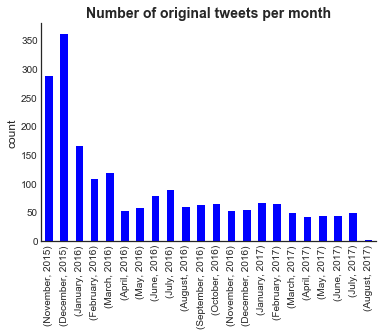

In [146]:
fig, ax = plt.subplots()
sns.set_style("white")
tweets_per_month.plot(kind='bar', color='b')
ax.set_title('Number of original tweets per month', fontsize=14, fontweight="bold")
ax.set_ylabel('count', fontsize=12)
ax.set_xlabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

* Podemos verificar no gráfico acima que os meses de Novembro e Dezembro de 2015 foram os que tiveram mais tweets originais excedento o patamar de 250 e 350 tweets respectivamente.

#### Em qual hora do dia WeRateDogs postou a maioria de seus tweets originais?

In [147]:
twitter_archive_master['Hour'].value_counts()

1     274
0     251
2     202
16    192
3     169
17    160
23    106
18    100
4      94
15     90
19     81
20     75
21     70
22     67
5      25
14      8
6       2
13      1
Name: Hour, dtype: int64

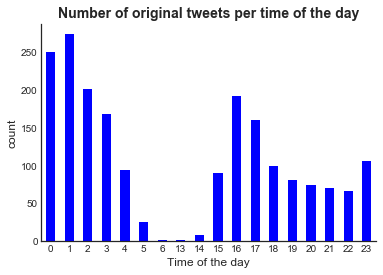

In [148]:
fig, ax = plt.subplots()
twitter_archive_master['Hour'].value_counts(sort=False).plot(kind='bar', color='b')
ax.set_title('Number of original tweets per time of the day', fontsize=14, fontweight="bold")
ax.set_ylabel('count', fontsize=12)
ax.set_xlabel('Time of the day', fontsize=12)
plt.xticks(rotation='horizontal') 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

* A maioria dos tweets foi publicada entre a meia-noite e as 3 da manhã. Em geral, o titular da conta WeRateDogs parece estar ativo a partir das 15h00. até às 5 da manhã todos os dias.

#### Qual foi o aplicativo do Twitter mais usado para postar tweets da WeRateDogs?

In [149]:
twitter_archive_master['source'].value_counts() / len(twitter_archive_master) * 100

Twitter for iPhone    98.068124
Twitter Web Client     1.321810
TweetDeck              0.559227
Name: source, dtype: float64

* Podemos verificar que o administrador da conta WeRateDogs gosta bastante de utilizar o iPhone com um total de 98% das vezes o aplicativo nativo do aparelho foi utilizado.